In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
from pathlib import Path
import kagglehub
from functools import lru_cache
from typing import Sequence
from math import log, isclose
import scipy.stats as st

np.set_printoptions(suppress=True)

In [2]:
# import
path = Path(kagglehub.dataset_download("mczielinski/bitcoin-historical-data")) / "btcusd_1-min_data.csv"
raw_records = pd.read_csv(
    path,
    usecols=["Open", "High", "Low", "Close", "Volume"],
    #nrows=100_000
)
first_datetime = datetime.fromisoformat(pd.read_csv(path, nrows=1).loc[0, "datetime"])
print("Done")

Done


In [3]:
# assigning a new index
datetime_index = pd.date_range(
    start=first_datetime,
    freq=timedelta(minutes=1),
    periods=raw_records.index[-1] + 1
)
records = raw_records
records.index = datetime_index
records.index.name = "datetime"
records.rename(columns=str.lower, inplace=True)
records.head()

,open,high,low,close,volume
datetime,,,,,
2012-01-01 10:01:00+00:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:02:00+00:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:03:00+00:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:04:00+00:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:05:00+00:00,4.58,4.58,4.58,4.58,0.0


In [4]:
# groping
daily_records = records.groupby(records.index.date).agg({
    "open": lambda x: x.iat[0],
    "high": "max",
    "low": "min",
    "close": lambda x: x.iat[-1],
    "volume": "sum"
})
daily_records.index = pd.DatetimeIndex(daily_records.index)
daily_records.tail()

,open,high,low,close,volume
2025-03-12,82941.0,84437.0,80607.0,83620.0,2469.218470
2025-03-13,83677.0,84287.0,79910.0,81079.0,1830.000892
2025-03-14,81084.0,85294.0,80801.0,83975.0,1986.995114
2025-03-15,83984.0,85059.0,82397.0,82961.0,1134.769801
2025-03-16,82921.0,83404.0,81983.0,82566.0,131.322533


---
**If you held bitcoin for up to 30 days where would your profit lie?**

In [15]:
# re-running the cell will clear all the cache!
@lru_cache
def profit_quantiles(
        record: pd.DataFrame,
        max_span: int = 30,
        quantiles: Sequence[float | int] = (0.01, 0.25, 0.5, 0.75, 0.99),
) -> pd.DataFrame:
    return_of_hold = pd.DataFrame({k: 0.0 for k in quantiles}, index=range(1, max_span + 1))
    grouped = record["close"].reset_index(drop=True)

    for span in range(2, max_span + 1):
        res = (grouped
               .rolling(window=span)
               .apply(lambda srs: (srs.iat[-1] / srs.iat[0] - 1) * 100)
               .quantile(quantiles)
               )
        return_of_hold.loc[span] = res
    return return_of_hold

In [20]:
# calculate the profit
MAX_SPAN_DAYS = 100
QUANTILES = (0.01, 0.25, 0.5, 0.75, 0.99)

return_of_hold = profit_quantiles(record=daily_records, max_span=MAX_SPAN_DAYS, quantiles=QUANTILES)
#return_of_hold.tail()

TypeError: unhashable type: 'DataFrame'

The profit will generally be positive with the 50% chance of it being between -12.83% and 58.0%, with median profit being 15.13%


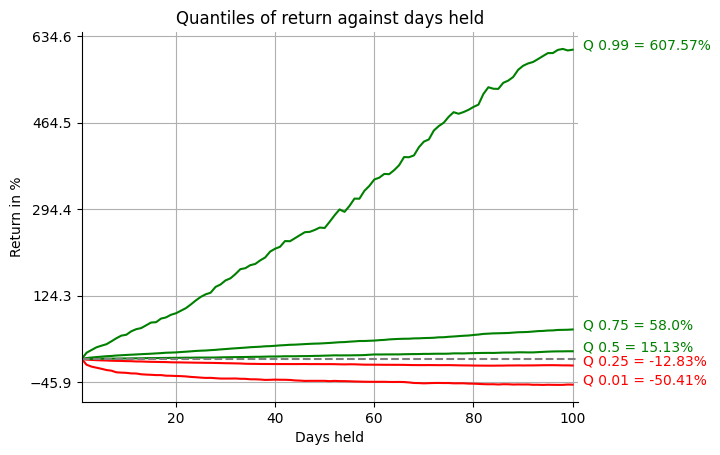

In [8]:
# charting
ax = plt.subplot()
for quantile, data in return_of_hold.items():
    if data.iat[-1] < 0:
        color = "red"
    elif data.iat[-1] == 0:
        color = "grey"
    else:
        color = "green"

    ax.plot(data, color=color)
    ax.text(x=MAX_SPAN_DAYS * 1.02, y=data.iat[-1], s=f"Q {round(quantile, 4)} = {round(data.iat[-1], 2)}%",
            color=color)

ax.axhline(0, linestyle="dashed", color="grey")

ax.set_title("Quantiles of return against days held")
ax.grid()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel("Days held")
ax.set_xlim(1, MAX_SPAN_DAYS * 1.01)

ax.set_yticks(
    np.arange(return_of_hold.min(axis=None) * 0.9, return_of_hold.max(axis=None) * 1.1,
              return_of_hold.mean(axis=None) * 3).round(2)
)
ax.set_ylabel("Return in %")
print(f"The profit will generally be positive with the 50% chance of it being between "
      f"{return_of_hold.iloc[-1, 1].round(2)}% and {return_of_hold.iloc[-1, 3].round(2)}%, "
      f"with median profit being {return_of_hold.iloc[-1, 2].round(2)}%")

---
**What would your profit be if you followed the MA-Cross strategy,\
whereby moving averages are 50 and 25-period MAs**

In [25]:
ma75 = records["close"].rolling(window=75).mean().dropna()
ma25 = records["close"].rolling(window=25).mean().dropna()

In [57]:
#def detect_crossings(ma25: pd.Series, ma50: pd.Series) -> pd.Series:
# cross under is defined as:
# t = 0: ma25 > ma50 + 2%
# t = 1->n: ma25 = ma50 +- 2%
# t = n + 1: ma25 = ma50 - 2%

# cross over is defined as:
# t = 0: ma25 < ma50 - 2%
# t = 1->n: ma25 = ma50 +- 2%
# t = n + 1: ma25 = ma50 + 2%

TypeError: must be real number, not NoneType

---
**How does price change correlate with change of trading volume?**

In [ ]:
QUANTILES = [0.05, 0.95]

volume_change = records["volume"].pct_change().dropna()
price_change = records["close"] / records["open"] - 1

price_volume_change = pd.concat([volume_change, price_change], axis="columns")
price_volume_change.rename(columns={"volume": "volume_change", 0: "price_change"}, inplace=True)

mask = price_volume_change.isin([np.nan, np.inf, -np.inf])
price_volume_change[mask] = 0

volume_mask = pd.qcut(price_volume_change["volume_change"], q=QUANTILES).isna().to_numpy()
price_mask = pd.qcut(price_volume_change["price_change"], q=QUANTILES).isna().to_numpy()

general_mask = np.stack([volume_mask, price_mask], axis=1).any(axis=1)

indices_to_drop = price_volume_change.loc[general_mask].index
price_volume_change.drop(indices_to_drop, inplace=True)
price_volume_change.tail()

In [ ]:
# charting
fig, ax = plt.subplots(figsize=(13, 5))
ax.scatter(
    x=price_volume_change["price_change"],
    y=price_volume_change["volume_change"],
    s=0.7,
    color="green"
)

ax.axvline(x=0, linestyle="dashed", color="grey")
ax.axhline(y=0, linestyle="dashed", color="grey")

ax.set_ylabel("Trading colume change")
ax.set_xlabel("Price change")
ax.set_title("Daily price change against change of trading volume (%)")

spearman = st.spearmanr(a=price_volume_change["price_change"], b=price_volume_change["volume_change"]).statistic.round(
    4)
print(f"Spearman rank correlation coefficient: {spearman}")
print("There is almost no correlation between these two values.")

---
**How does halving affect price and trading volume?**

In [ ]:
halving_dates = (
    date(year=2012, month=11, day=28),
    date(year=2016, month=7, day=9),
    date(year=2020, month=7, day=10),
    date(year=2024, month=4, day=20),
)

grouped = (records
           .groupby([records.index.year, records.index.month])
           .agg({"close": "median", "volume": "sum"})
           .reset_index(drop=True)
           )
grouped.index = pd.date_range(start=first_datetime, freq=timedelta(days=30), periods=len(grouped))

In [ ]:
ax = plt.subplot()
ax.plot(grouped["close"].map(log), color="blue")
ax.set_title("Bitcoin price development after each halving")
ax.set_xlabel("Year")
ax.set_ylabel("Log price in $")

for date in halving_dates:
    ax.axvline(x=date, linestyle="dashed", color="green", label="halving date")

ax.legend(ax.get_children()[:2], ["Log price", "Halving"])
print("There used to be a visible correlation between the halving and a significat price jump.\n"
      "In the 2024 this jump is however much smaller than other times")

---
**How did trading volume per dollar change over the years?**

In [ ]:
grouped = (records
           .groupby([records.index.year, records.index.month])
           .agg({"close": "median", "volume": "sum"})
           .reset_index(drop=True)
           )
grouped.index = pd.date_range(start=first_datetime, freq=timedelta(days=30), periods=len(grouped))
volume_per_dollar = grouped["volume"] / grouped["close"]

In [ ]:
ax = plt.subplot()

ax.plot(volume_per_dollar.map(log), color="green")
ax.set_ylabel("Log Trading volume per dollar")
ax.set_xlabel("Year")
ax.set_title("Trading volume per dollar price over time");
print("Sinking trading volume per dollar is a signal of the price growing faster than the trading volume.\n"
      "This in turn may imply that the Bitcoin has become much more of a speculation tool than a real valuable asset.")